In [3]:
from FPSim2 import FPSim2Engine
from trialblazer.Dataset_characterization.physicochem_properties_calculation import *
from characterization import *
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

[15:14:19] Initializing Normalizer


In [4]:
import warnings
warnings.filterwarnings('ignore')

Training set

In [5]:
Training_data = pd.read_csv("../Data/Training_data_withoutInfo.csv", sep='|')
print(Training_data.Mark.value_counts())
trainging_toxic_set = Training_data[Training_data.Mark == 1]
training_benign_set = Training_data[Training_data.Mark == 0]

Mark
0    1603
1     238
Name: count, dtype: int64


Test set

In [6]:
testset_new= pd.read_csv('../Data/test_set_data.csv')
print(len(testset_new))
testset_new.Mark = 0
testset_new['db'] = 'Test set'

339


# UMAP

In [7]:
benign_set = training_benign_set[['SmilesForDropDu']]
toxic_set = trainging_toxic_set[['SmilesForDropDu']]
benign_set['db'] = 'benign_drugs'
toxic_set['db'] = 'toxic_drugs'

In [8]:
get_physicochemical_properties(benign_set,'SmilesForDropDu')
get_physicochemical_properties(toxic_set,'SmilesForDropDu')
get_physicochemical_properties(Training_data,'SmilesForDropDu')
get_physicochemical_properties(testset_new,'SmilesForDropDu')

In [9]:
get_further_physicochemical_properties(Training_data)
get_further_physicochemical_properties(testset_new)
get_further_physicochemical_properties(benign_set)
get_further_physicochemical_properties(toxic_set)

In [10]:
Training_data_sim = Training_data[['SmilesForDropDu', 'Molecule', 'N', 'O', 'chiral', 'MW', 'heavy_atoms', 'h_acc', 'h_don', 'logP', 'TPSA', 'numAro','formalCharge', 'frac_csp3', 'S', 'nHalogens', 'MR']]
testset_sim = testset_new[['SmilesForDropDu', 'Molecule', 'N', 'O', 'chiral', 'MW', 'heavy_atoms', 'h_acc', 'h_don', 'logP', 'TPSA', 'numAro','formalCharge', 'frac_csp3', 'S', 'nHalogens', 'MR']]

In [11]:
Training_data_sim['db'] = 'Training set'
testset_sim['db'] = 'Test set'

Visualize the chemical space

In [12]:
trainingandtestset_df, scaled_property_data_trianingandtest, morgan2_cols_trianingandtest = data_to_visualize_umap(Training_data_sim, testset_sim)
benignandtoxic_df, scaled_property_data_benignandtoxic, morgan2_cols_benignandtoxic = data_to_visualize_umap(benign_set, toxic_set)

function here is for figure drawing, need to be removed after the figure is done

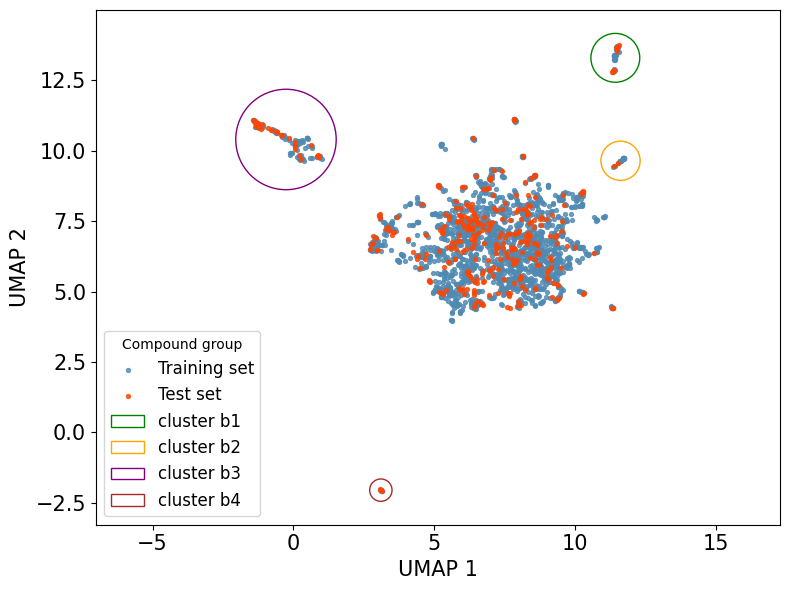

In [14]:
plot_umap_trainingAndtext_morgan2(
    morgan2_cols_trianingandtest, 
    trainingandtestset_df,
)

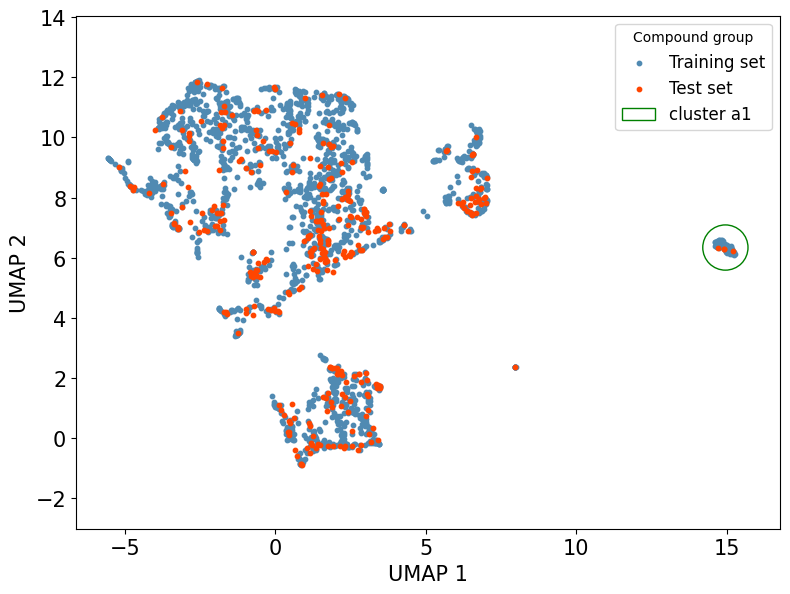

In [16]:
plot_umap_trainingAndtext_physichem(
    scaled_property_data_trianingandtest, 
    trainingandtestset_df
)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


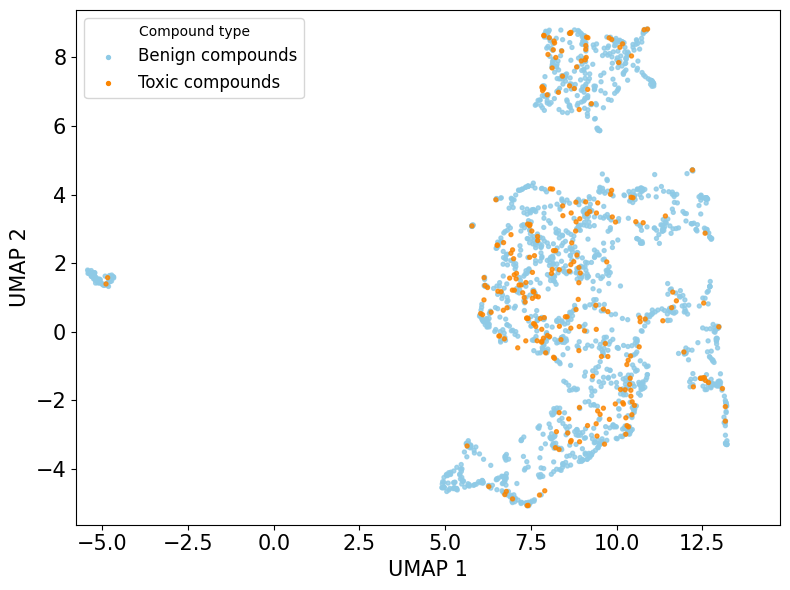

In [18]:
plot_umap_benignAndtoxic(scaled_property_data_benignandtoxic, benignandtoxic_df)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


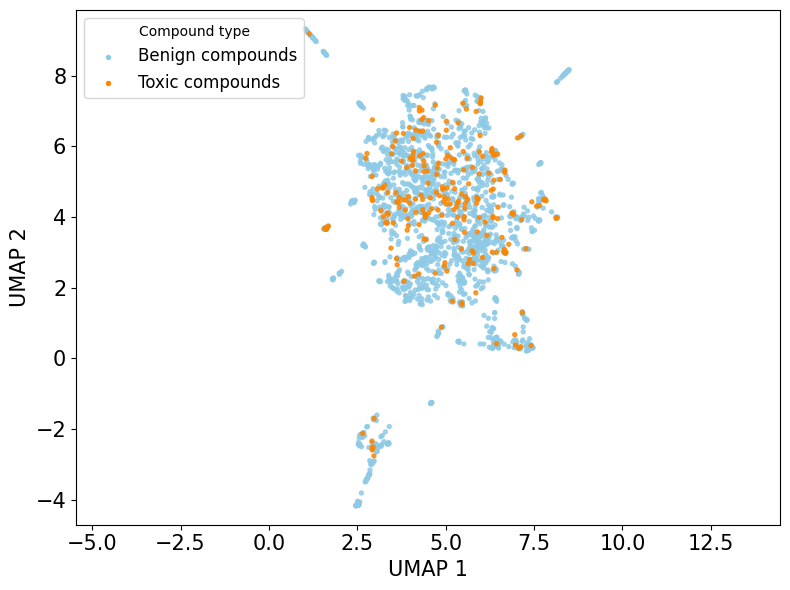

In [20]:
plot_umap_benignAndtoxic(morgan2_cols_benignandtoxic, benignandtoxic_df)

# Pairwise tanimoto similarity

## Similairty comparison between two classes of data in training set

Generated h5 file of benign class using FPSim2Engine

In [15]:
list_smi_benign = benign_set['SmilesForDropDu'].tolist()
benign_h5 = '../Data/Benign_set.h5'
benign_fpe = FPSim2Engine(benign_h5)

Calculate tanimoto similarity

In [16]:
similairty_results = pairwise_tanimoto_similarity(list_smi_benign, toxic_set, benign_fpe)

Calculating similarities: 100%|██████████| 238/238 [00:29<00:00,  8.12it/s]


Select the closest neighbors and plot the figure

In [17]:
closest_neighbors_training = np.max(similairty_results[list_smi_benign], axis=1)
steps = np.linspace(0, 1, 10000)

In [18]:
# Calculate the percentage of compounds with a Tanimoto similarity coefficient greater than or equal to each sampling point from 0 to 1
sim_bins_training = [((closest_neighbors_training >= s).sum() / closest_neighbors_training.shape[0])* 100 for s in steps]

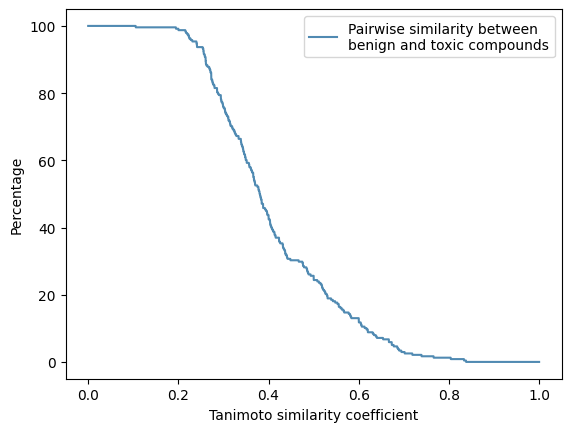

In [19]:
plt.plot(steps, sim_bins_training, label='Pairwise similarity between\nbenign and toxic compounds', color='#508AB2')
plt.xlabel('Tanimoto similarity coefficient')
plt.ylabel('Percentage')
plt.legend(loc='upper right')

## Similarity comparison between training set and test sets

In [20]:
list_smi_training = Training_data['SmilesForDropDu'].tolist()
list_smi_approvaldrugs = testset_new['SmilesForDropDu'].tolist()

In [21]:
outputFolder = '../Data/training_data.h5'
training_fpe = FPSim2Engine(outputFolder)

Calculate tanimoto similarity between training set and tests sets

In [22]:
pairwise_similarity_result = pairwise_tanimoto_similarity(list_smi_training,testset_new, training_fpe)

Calculating similarities: 100%|██████████| 339/339 [00:39<00:00,  8.62it/s]


Plot the pairwise similarity figure

In [23]:
masked_array_ApprovalDrugs = np.where(pairwise_similarity_result[list_smi_training] == 1, -np.inf, pairwise_similarity_result[list_smi_training])
masked_array_ApprovalDrugs = masked_array_ApprovalDrugs.T

In [24]:
closest_neighbors_approvaldrugs = np.max(masked_array_ApprovalDrugs, axis=1)
steps = np.linspace(0, 1, 10000)
sim_bins_approvaldrugs = [((closest_neighbors_approvaldrugs >= s).sum() / closest_neighbors_approvaldrugs.shape[0])* 100 for s in steps]

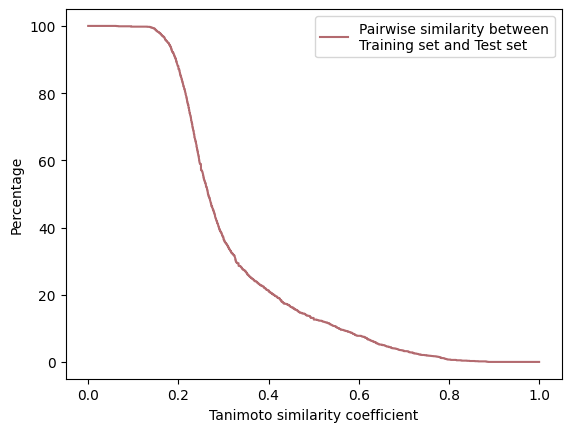

In [25]:
plt.plot(steps, sim_bins_approvaldrugs,label='Pairwise similarity between\nTraining set and Test set',color='#B36A6F')
plt.xlabel('Tanimoto similarity coefficient')
plt.ylabel('Percentage')
plt.legend(loc='upper right')

## Visualize the chemical structure of the most similar compounds between two classes in training set

Select the compound pairs where the Tanimoto similarity is greater than 0.6

In [26]:
similar_compounds_pd = pd.DataFrame()
similar_compounds = []
li_append = []
dw_toxic = []
for i, series in enumerate(similairty_results[list_smi_benign]):
        similarity_values = list(similairty_results.get(series))
        for a, li in enumerate(similarity_values):
            if li >= 0.6:
                similar_compounds.append(similairty_results.smi[a])
                dw_toxic.append(similairty_results.smi[a])
                li_append.append(li)
                similar_compounds.append(series)
                li_append.append(li)
similar_compounds_pd['similar_compounds_pairs'] = similar_compounds
similar_compounds_pd['mol'] = similar_compounds_pd['similar_compounds_pairs'].apply(Chem.MolFromSmiles)
similar_compounds_pd['tanimoto_similarity'] = li_append

In [27]:
similar_compounds_pd = pd.DataFrame()
similar_compounds = []
li_append = []
dw_toxic = []
for i, series in enumerate(similairty_results[list_smi_benign]):
        similarity_values = list(similairty_results.get(series))
        for a, li in enumerate(similarity_values):
            similar_compounds.append(similairty_results.smi[a])
            dw_toxic.append(similairty_results.smi[a])
            li_append.append(li)
            similar_compounds.append(series)
            li_append.append(li)
similar_compounds_pd['similar_compounds_pairs'] = similar_compounds
similar_compounds_pd['mol'] = similar_compounds_pd['similar_compounds_pairs'].apply(Chem.MolFromSmiles)
similar_compounds_pd['tanimoto_similarity'] = li_append

In [28]:
top_10_similar = similar_compounds_pd.sort_values(by='tanimoto_similarity', ascending=False).head(20)
identifiers = [(i // 2) + 1 for i in range(20)]
top_10_similar['pair'] = identifiers

Graphic-grid

In [29]:
top_10_similar['mol_with_stereo'] = top_10_similar['similar_compounds_pairs'].apply(Chem.MolFromSmiles)

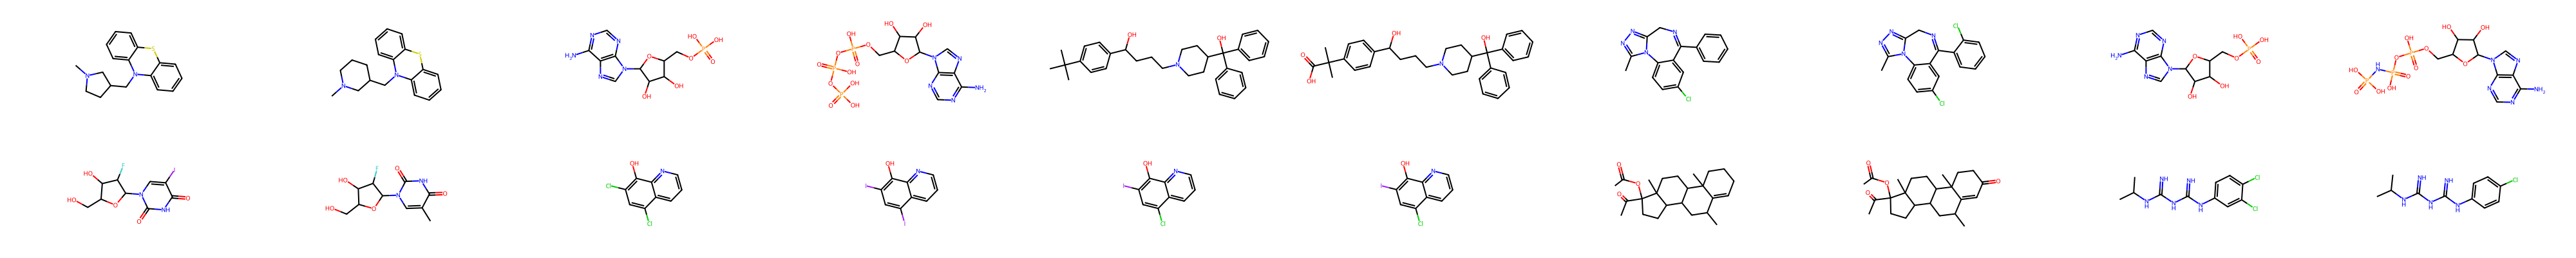

In [30]:
drawing_options = Chem.Draw.rdMolDraw2D.MolDrawOptions()
drawing_options.legendFontSize = 30
img = Chem.Draw.MolsToGridImage(list(top_10_similar['mol_with_stereo']),molsPerRow=10,subImgSize=(400,200), returnPNG=False, drawOptions=drawing_options)
img

# Physicochemical properties comparision

Descriptors calculation

In [22]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList]);
desc_cols = list(calc.GetDescriptorNames())

In [23]:
Training_data = desc_calculation(Training_data, desc_cols)
testset = desc_calculation(testset_new, desc_cols)

In [24]:
benign_set = Training_data[Training_data['Mark'] == 0]
toxic_set = Training_data[Training_data['Mark'] == 1]

In [25]:
selected_desc = ['MolWt', 'NumHAcceptors','NumHDonors','MolLogP', 'FractionCSP3','NumAromaticRings']

Statistical analysis of the physicochemical properties

In [26]:
(benign_set[selected_desc].mean(axis=0).round(2))- (toxic_set[selected_desc].mean(axis=0).round(2))

MolWt               35.31
NumHAcceptors        0.89
NumHDonors           0.47
MolLogP             -0.36
FractionCSP3         0.12
NumAromaticRings    -0.23
dtype: float64

In [27]:
print(benign_set[selected_desc].mean(axis=0).round(2))
print(benign_set[selected_desc].std(axis=0).round(2))
print(toxic_set[selected_desc].mean(axis=0).round(2))
print(toxic_set[selected_desc].std(axis=0).round(2))

MolWt               374.39
NumHAcceptors         5.10
NumHDonors            2.01
MolLogP               2.61
FractionCSP3          0.47
NumAromaticRings      1.61
dtype: float64
MolWt               140.55
NumHAcceptors         3.16
NumHDonors            1.97
MolLogP               2.62
FractionCSP3          0.26
NumAromaticRings      1.24
dtype: float64
MolWt               339.08
NumHAcceptors         4.21
NumHDonors            1.54
MolLogP               2.97
FractionCSP3          0.35
NumAromaticRings      1.84
dtype: float64
MolWt               110.17
NumHAcceptors         2.33
NumHDonors            1.61
MolLogP               2.04
FractionCSP3          0.23
NumAromaticRings      1.07
dtype: float64


Plot the figures

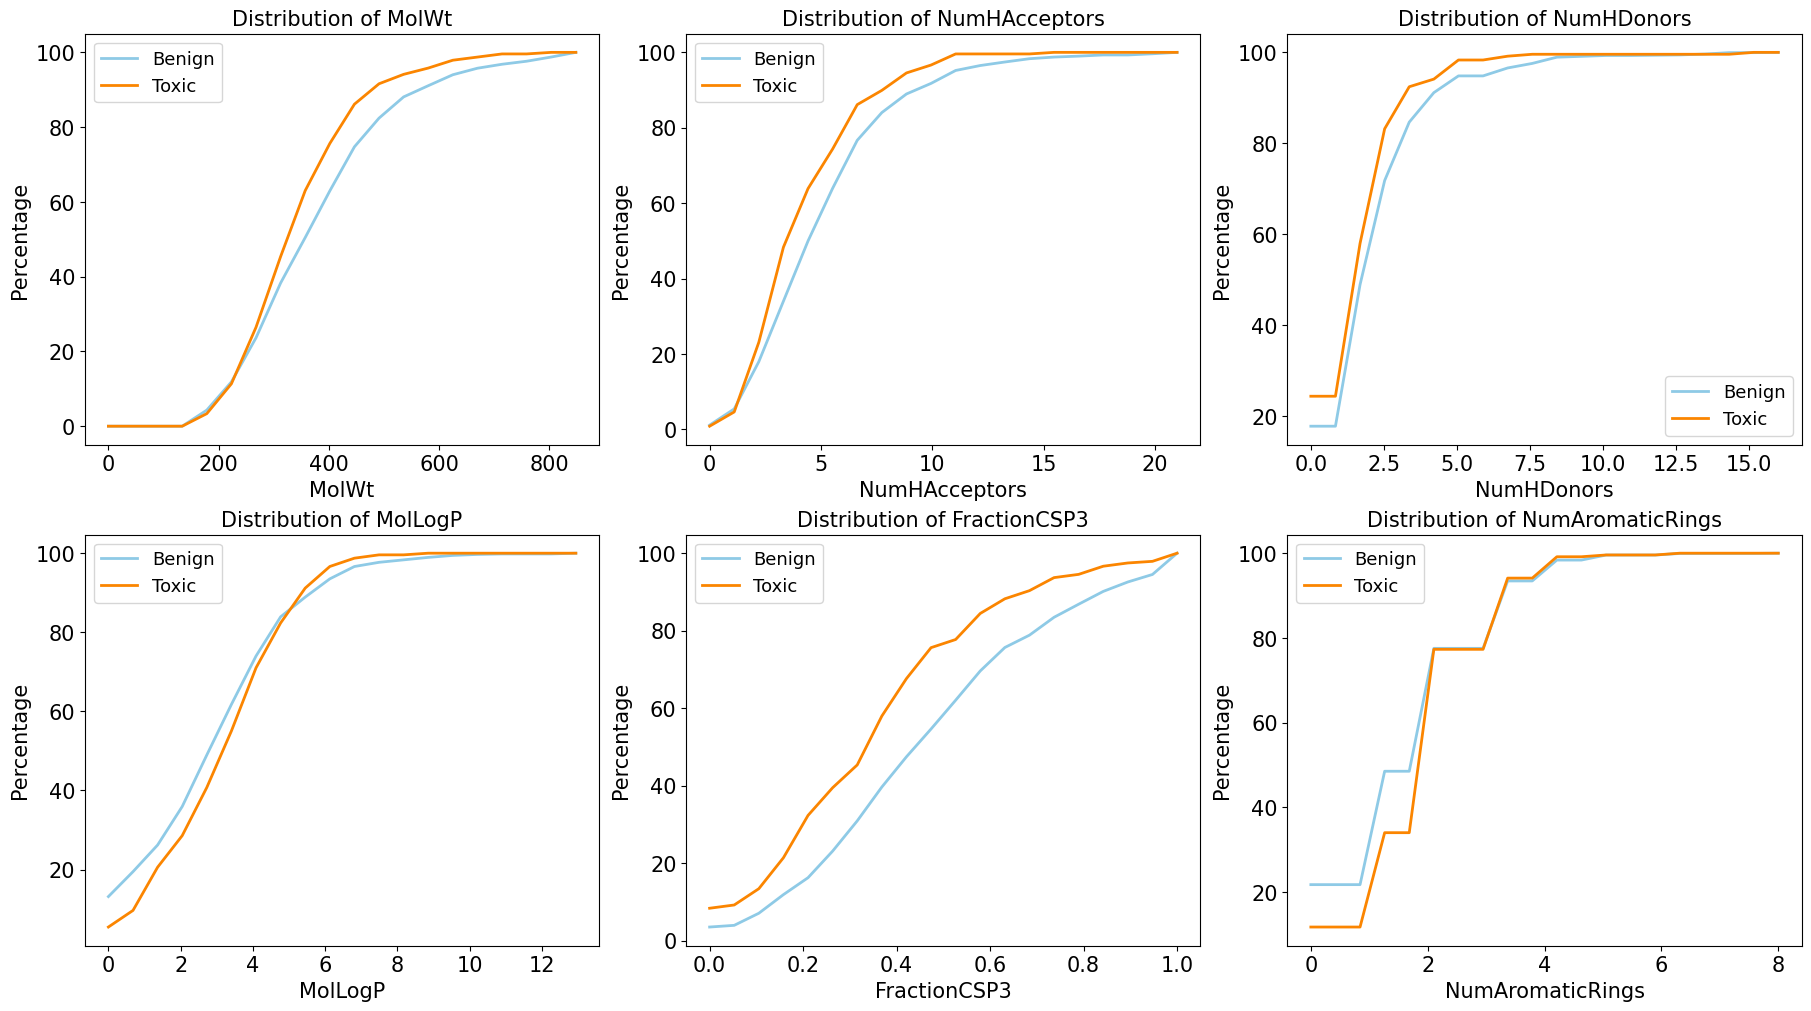

In [29]:
plot_distribution_of_physichem_prop(Training_data, selected_desc, benign_set, toxic_set)

# Murcko scaffolds matching

In [30]:
toxic = add_murcko_scaffold(toxic_set)
benign = add_murcko_scaffold(benign_set)

Common scaffolds in two classes

In [31]:
toxic_MS_list = set(toxic['MurckoScaffold_smi'])
Same_Murcko = benign[benign['MurckoScaffold_smi'].isin(toxic_MS_list)]

In [32]:
Same_Murcko_drop = Same_Murcko.drop_duplicates(subset= ['MurckoScaffold_smi'])
shared_scaffold = Same_Murcko_drop['MurckoScaffold_smi'].tolist()
# Filter dataframes for shared scaffolds
shared_benign = benign[benign.MurckoScaffold_smi.isin(shared_scaffold)]
shared_toxic = toxic[toxic.MurckoScaffold_smi.isin(shared_scaffold)]
# Count occurrences and calculate percentages
shared_toxic_count = shared_toxic.groupby('MurckoScaffold_smi').size().reset_index(name='count_toxic')
shared_benign_count = shared_benign.groupby('MurckoScaffold_smi').size().reset_index(name='count_benign')
shared_toxic_count['percentage_toxic'] = (shared_toxic_count['count_toxic'] / 238) * 100
shared_benign_count['percentage_benign'] = (shared_benign_count['count_benign'] / 1603) * 100
# Merge and calculate difference
merged_two_classes = shared_toxic_count.merge(shared_benign_count, on='MurckoScaffold_smi', how='left')
merged_two_classes['difference'] = round(merged_two_classes['percentage_toxic'] - merged_two_classes['percentage_benign'], 2)

Overview of the unique caffolds in two classes

In [33]:
round(merged_two_classes.sort_values(by='difference', ascending=False).head(5),2)

,MurckoScaffold_smi,count_toxic,percentage_toxic,count_benign,percentage_benign,difference
34,c1ccccc1,28,11.76,115,7.17,4.59
27,c1ccc(Cc2ccccc2)cc1,6,2.52,8,0.50,2.02
4,O=C(Nc1ccccc1)c1ccccc1,5,2.10,2,0.12,1.98
30,c1ccc2ccccc2c1,5,2.10,5,0.31,1.79
26,c1ccc(CCc2ccccc2)cc1,3,1.26,1,0.06,1.20


Number of unique MurckoScaffolds in benign set: 1025
Number of unique MurckoScaffolds in toxic set: 167
Number of shared scaffolds between two sets: 38
Percentage of shared scaffolds in query set: 22.75%
Size of the largest MurckoScaffold cluster in query set: 28


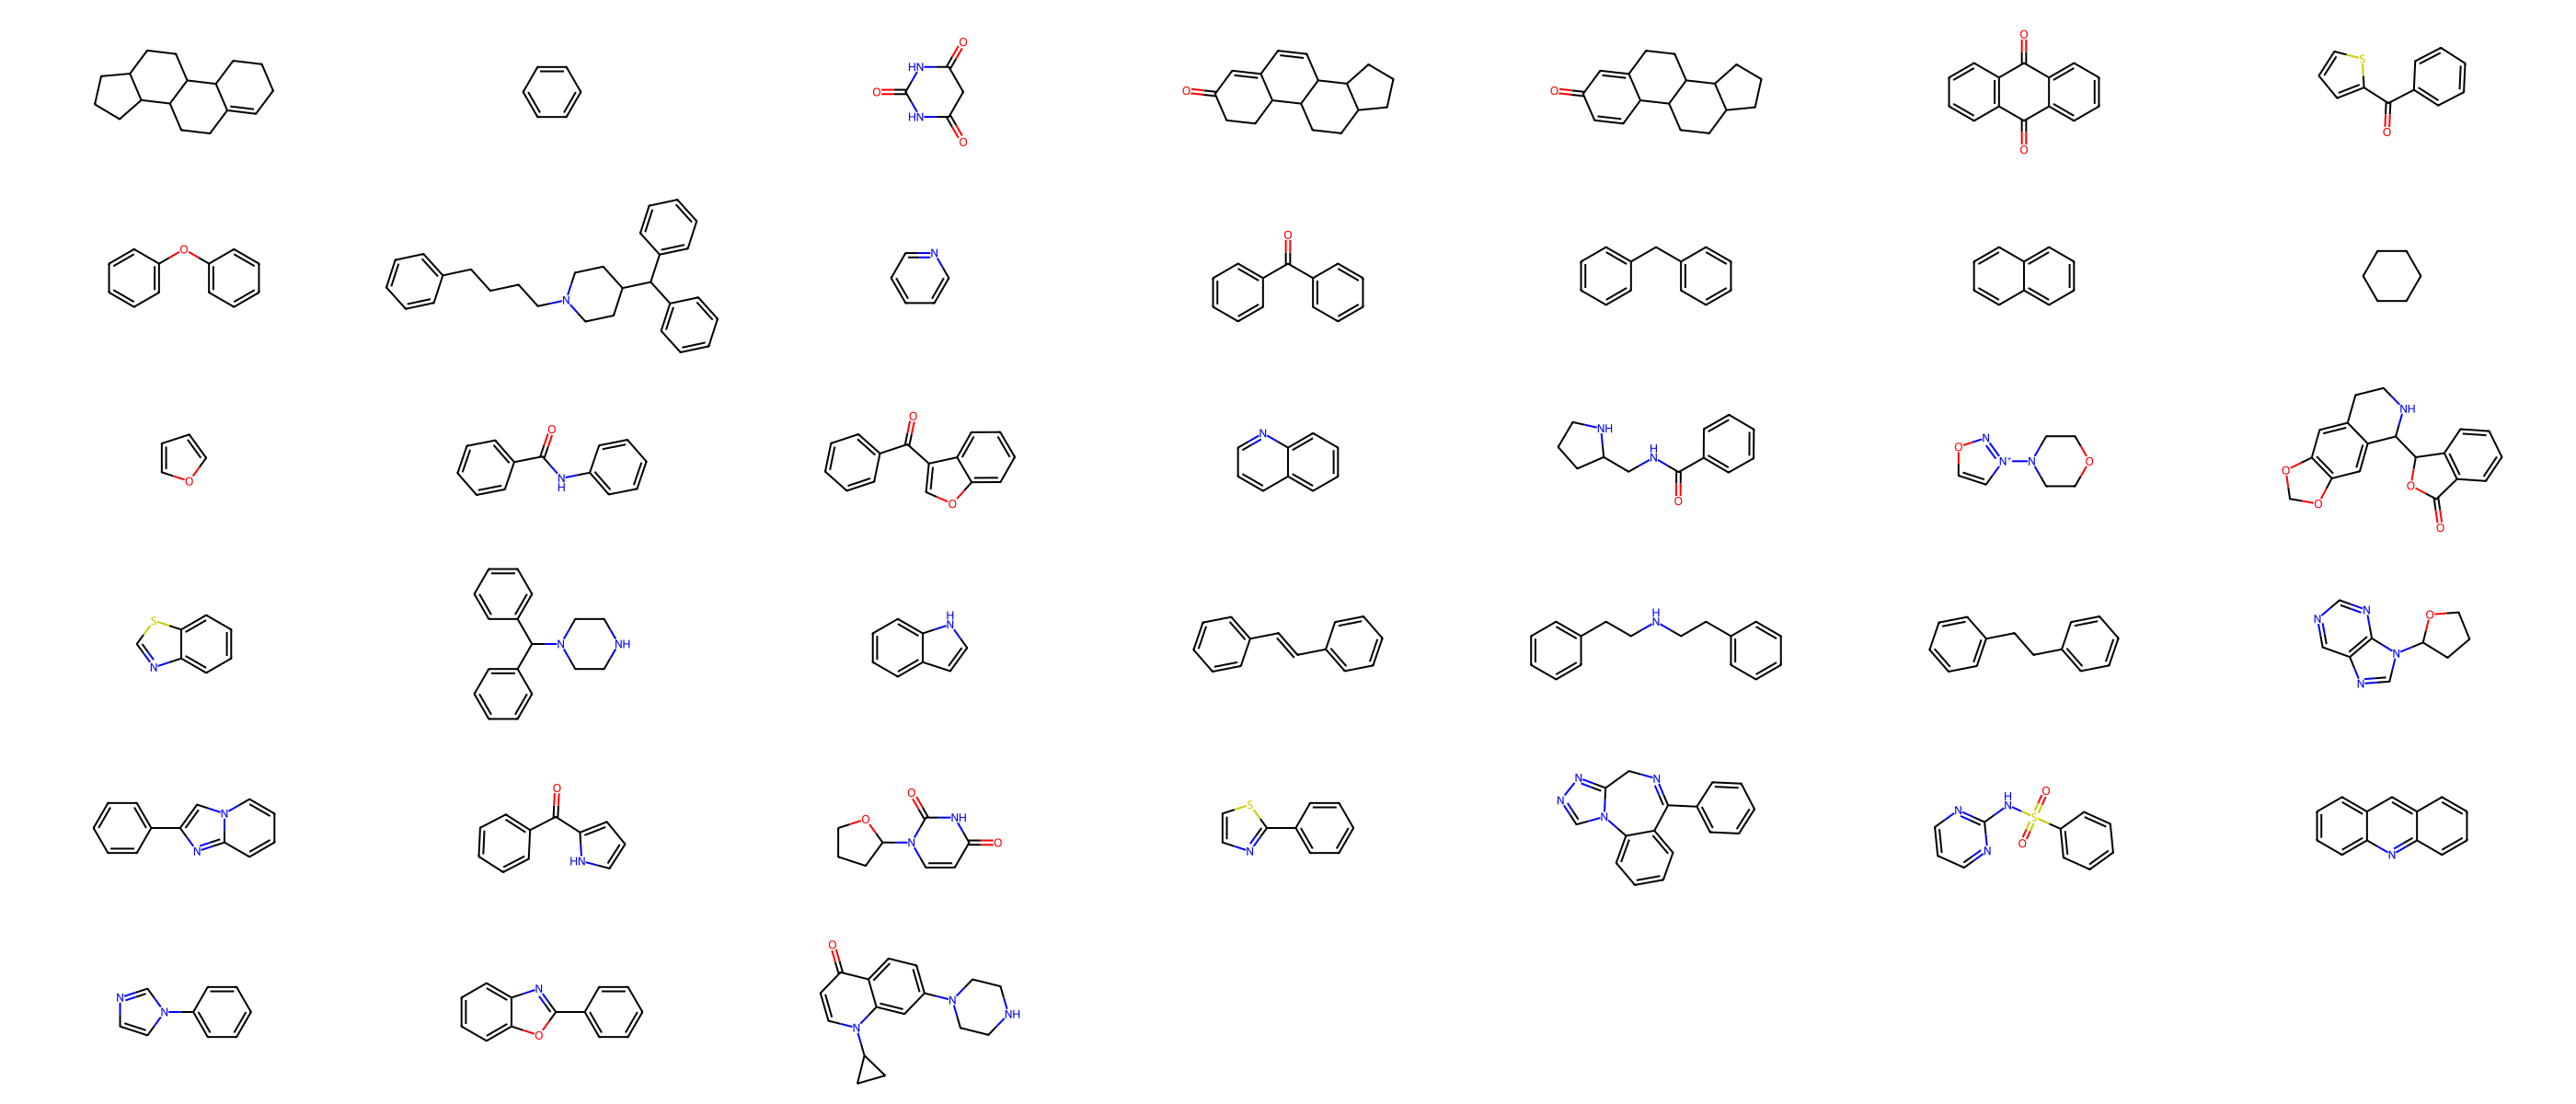

In [34]:
count_shared_scaffold(benign, toxic, img=True)

Most prominent scaffolds among benign and toxic compounds

In [35]:
toxic_notempty_count = toxic.groupby('MurckoScaffold_smi')['MurckoScaffold_smi'].count().sort_values(ascending=False)
benign_notempty_count = benign.groupby('MurckoScaffold_smi')['MurckoScaffold_smi'].count().sort_values(ascending=False)

In [36]:
toxic_notempty_count.head(5)

MurckoScaffold_smi
c1ccccc1                           28
c1ccc(Cc2ccccc2)cc1                 6
O=C(Nc1ccccc1)c1ccccc1              5
c1ccc2ccccc2c1                      5
O=C1CC(=O)N(c2ccccc2)N1c1ccccc1     4
Name: MurckoScaffold_smi, dtype: int64

In [37]:
benign_notempty_count.head(5)

MurckoScaffold_smi
c1ccccc1                           115
O=C1C=CC2C(=C1)CCC1C3CCCC3CCC21     27
O=C1C=C2CCC3C4CCCC4CCC3C2CC1        22
c1ccc(Cc2ccccc2)cc1                  8
C1CCCCC1                             8
Name: MurckoScaffold_smi, dtype: int64

In [38]:
round(((toxic_notempty_count /238)*100),2).head(5)

MurckoScaffold_smi
c1ccccc1                           11.76
c1ccc(Cc2ccccc2)cc1                 2.52
O=C(Nc1ccccc1)c1ccccc1              2.10
c1ccc2ccccc2c1                      2.10
O=C1CC(=O)N(c2ccccc2)N1c1ccccc1     1.68
Name: MurckoScaffold_smi, dtype: float64

In [39]:
round(((benign_notempty_count /1603)*100),2).head(5)

MurckoScaffold_smi
c1ccccc1                           7.17
O=C1C=CC2C(=C1)CCC1C3CCCC3CCC21    1.68
O=C1C=C2CCC3C4CCCC4CCC3C2CC1       1.37
c1ccc(Cc2ccccc2)cc1                0.50
C1CCCCC1                           0.50
Name: MurckoScaffold_smi, dtype: float64

# Functional group analysis

In [40]:
SMARTS_list = pd.read_csv("../Data/SMARTS_list_InteLigand.csv")

In [41]:
SMARTS_list['SMARTS_pattern'] = SMARTS_list['SMARTS_pattern'].astype(str)
SMARTS_list['mol_pattern'] = SMARTS_list['SMARTS_pattern'].apply(Chem.MolFromSmarts)
SMARTS_list = SMARTS_list.dropna(subset=['mol_pattern']).reset_index()
SMARTS_list.Pattern_name = SMARTS_list.Pattern_name.str.rstrip(':')
Pattern_name = SMARTS_list.Pattern_name.to_list()

In [42]:
funtional_group_benign = functional_group_analysis(benign, SMARTS_list)
funtional_group_toxic = functional_group_analysis(toxic, SMARTS_list)
funtional_group_benign_nona = funtional_group_benign[funtional_group_benign.SMARTS_pattern != 'nan']
funtional_group_toxic_nona = funtional_group_toxic[funtional_group_toxic.SMARTS_pattern != 'nan']

In [43]:
count_toxic = (funtional_group_toxic_nona.groupby('SMARTS_pattern')['Pattern_name'].count().reset_index(name='pattern_count_toxic').sort_values(by='pattern_count_toxic', ascending=False))
count_benign = (funtional_group_benign_nona.groupby('SMARTS_pattern')['Pattern_name'].count().reset_index(name='pattern_count_benign').sort_values(by='pattern_count_benign', ascending=False))

In [44]:
print(count_benign['pattern_count_benign'].sum())
print(count_toxic['pattern_count_toxic'].sum())

24153
3308


In [45]:
count_benign['percentage_benign'] = (count_benign.pattern_count_benign / 24153)*100
count_toxic['percentage_toxic'] = (count_toxic.pattern_count_toxic / 3308)*100

In [46]:
outer = count_benign.merge(count_toxic, how='outer', on='SMARTS_pattern')
outer_fillna = outer.fillna(0)
outer_fillna['difference'] = outer_fillna['percentage_benign'] - outer_fillna['percentage_toxic']

In [47]:
outer_fillna_difference = outer_fillna.sort_values(by='difference', ascending=False).head(10)
outer_fillna_difference_withname = outer_fillna_difference.merge(SMARTS_list[['SMARTS_pattern','Pattern_name']], on='SMARTS_pattern', how='left')

In [48]:
outer_fillna_difference_withname.head(10).round(2)

,SMARTS_pattern,pattern_count_benign,percentage_benign,pattern_count_toxic,percentage_toxic,difference,Pattern_name
0,"[OX2H][CX4;!$(C([OX2H])[O,S,#7,#15])]",460.0,1.90,32.0,0.97,0.94,Alcohol
1,"[OX2H][CX4H;!$(C([OX2H])[O,S,#7,#15])]",307.0,1.27,20.0,0.60,0.67,Secondary_alcohol
2,"[OX2H][CX4H2;!$(C([OX2H])[O,S,#7,#15])]",167.0,0.69,10.0,0.30,0.39,Primary_alcohol
3,[R;$(*(@*)(@*)@*);!$([R2;$(*(@*)(@*)(@*)@*)])]...,802.0,3.32,99.0,2.99,0.33,Annelated_rings
4,"[OX2]([CX4;!$(C([OX2])[O,S,#7,#15,F,Cl,Br,I])]...",154.0,0.64,12.0,0.36,0.27,Dialkylether
5,"[NX3v3,SX2,OX2;$(**=[#7,#8,#15,#16])][CX4;!$(C...",73.0,0.30,1.0,0.03,0.27,Hetero_methylen_ester_and_similar
6,[nX3H1+0],159.0,0.66,13.0,0.39,0.27,Hetero_N_basic_H
7,"[NX3v3,SX2,OX2;$(**=[#7,#8,#15,#16])][CX4;!$(C...",69.0,0.29,1.0,0.03,0.26,NOS_methylen_ester_and_similar
8,"[OX2H][CX4;!$(C([OX2H])[O,S,#7,#15,F,Cl,Br,I])...",105.0,0.43,6.0,0.18,0.25,"1,2-Aminoalcohol"
9,[CX4H1]([#6])([#6])[#6],506.0,2.09,61.0,1.84,0.25,Tertiary_carbon
